# Sentiment classification
> The task of classifying sentiments of texts (for example movie or product reviews) has high practical significance in online marketing as well as financial prediction. This is a non-trivial task, since the concept of sentiment is not easily captured. [IMDB sentiment](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) benchmark dataset from Stanford is used.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/chart-preview.png

# Data download

In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz
!ls

--2020-12-04 12:11:02--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  20.3MB/s    in 7.1s    

2020-12-04 12:11:09 (11.3 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

aclImdb  aclImdb_v1.tar.gz  sample_data


# Alternative with tf.datasets

I imported data in my own way since i thought it would be a good idea to do semi supervised traiing also using the unsupervised text.

In [ ]:
def read_file(path):
    with open(path, 'rt', encoding='utf-8') as file:
        lines = file.readlines()
        text = " ".join(lines)

    return text

In [ ]:
import glob
import os

In [ ]:
def getData():
    path_posttrain = os.path.join('aclImdb/train/', "pos", "*.txt")
    path_negtrain = os.path.join('aclImdb/train/', "neg", "*.txt")
    postrain = glob.glob(path_posttrain)
    negtrain = glob.glob(path_negtrain)
    data_pos_train = [read_file(path) for path in postrain]
    data_neg_train = [read_file(path) for path in negtrain]  
    

    path_unsup = os.path.join('aclImdb/train/', "unsup", "*.txt")
    unsup = glob.glob(path_unsup)
    unsup_train = [read_file(path) for path in unsup]  


    path_postest = os.path.join('aclImdb/test/', "pos", "*.txt")
    path_negtest = os.path.join('aclImdb/test/', "neg", "*.txt")
    postest = glob.glob(path_postest)
    negtest = glob.glob(path_negtest)

    data_pos_test = [read_file(path) for path in postest]
    data_neg_test = [read_file(path) for path in negtest]  


    return data_pos_train+data_neg_train,[1.0] * len(data_pos_train) + [0.0] * len(data_neg_train),data_pos_test+data_neg_test,[1.0] * len(data_pos_test) + [0.0] * len(data_neg_test),unsup_train

In [ ]:
trainX,trainY,testX,testY,unsup=getData()

In [ ]:
trainX[0],trainY[0]

("A couple(Janet and Richard) go camping out in the woods near a giant swamp. After camping and enjoying nature, the couple takes shelter in what they think is an abandoned farm house. Soon, a pair of escaped convicts show up and, after much delaying of the inevitable, they proceed to rape Janet and lock Richard in a birdcage.<br /><br />This LAST HOUSE ON THE LEFT-like film has to be one of the most underrated horror films ever made. It's one of the more sick and twisted early 70s shockers. Moreover, I found this to be quite enchanting and beautiful in it's perverse tone. I love CAGED TERROR. The music definitely helps lend a sense of personality to the film as well as a lot of beauty. I found the film to be quite creepy.<br /><br />The flaws mainly have to do with the pacing of the film, which is to say that the film is rather slow and meandering. While I didn't mind the pacing due to the beauty and suspense of the film in question, I do think that it will both most people. The actin

In [ ]:
testX[0],testY[0]

("This Metro film is episodic, but nearly a constant series of chases, mainly trying to escape police, whether real or imagined, as Buster is mistaken for an escaped criminal. It is consistently inventive and entertaining. Its greatest value is in its documenting what Hollywood looked like in the early twenties, since 95% of it is shot outside among the streets and building exteriors of the time. One gem moment and one gem sequence are present here.<br /><br />The great moment is when a train at a great distance quickly approaches the camera and finally stops just short of it - with Buster glumly sitting on the cowcatcher and thus moving from a long shot to a close-up within seconds.<br /><br />The great sequence is with the phone booth next to the elevator - one constantly being mistaken for the other with races from floor to floor - one of the great Keaton gags.<br /><br />Kino's print is sharp and clear - almost pristine. There is a violin/piano score accompaniment. This is one to s

In [ ]:
import pandas as pd

In [ ]:
unsupDf=pd.DataFrame(unsup,columns=['Text'])

In [ ]:
trainDf=pd.DataFrame(trainX,columns=['Text'])

In [ ]:
testDf=pd.DataFrame(testX,columns=['Text'])

In [ ]:
trainDf['Label']=trainY

In [ ]:
testDf['Label']=testY

In [ ]:
trainDf=trainDf.sample(frac=1).reset_index(drop=True)

In [ ]:
testDf=testDf.sample(frac=1).reset_index(drop=True)

In [ ]:
trainDf.to_csv('train.csv')
testDf.to_csv('test.csv')

In [ ]:
trainPlusUnsupDf=pd.concat([unsupDf['Text'],trainDf['Text']])

In [ ]:
trainPlusUnsupDf=pd.DataFrame(trainPlusUnsupDf,columns=['Text'])

I use spacy here for text preprocessing for bag  of words based model which i use as a tokenizer in the input of tfidf vectorizer. So spacy here toenizes and cleans as well.

In [ ]:
%%capture
!pip install spacy
!pip install en_core_web_sm
!pip install optuna

In [ ]:
import spacy

Diabled tagger and other part of pipelines since they take it takes a lot of time to run or else.

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner','tagger'])

In [ ]:
nlp.Defaults.stop_words.update(['from', 'subject', 're', 'edu', 'use', 'not', 
                               'would', 'say', 'could', '_', 'be', 'know', 'good', 
                               'go', 'get', 'do', 'done', 'try', 'many', 'some',
                               'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily',
                               'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even',
                               'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [ ]:
import string

also using regex for basic text preprocessing for deep learning and fastext models. which i just clearing html texts ensuring only alphanumeric characters are there and replacing number with  num tag.

In [ ]:
from bs4 import BeautifulSoup

# Cleaning

In [ ]:
import re
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)
    
#a good idea to replace all the numbers with a special token
def replace_num(text):
    return re.sub(r'[0-9]', '__NUM__', text)


In [ ]:
trainPlusUnsupDf['Text'] = trainPlusUnsupDf['Text'].str.lower()
trainPlusUnsupDf['Text']=  trainPlusUnsupDf['Text'].apply(lambda x:BeautifulSoup(x,'html.parser').get_text())
trainPlusUnsupDf['Text'] = trainPlusUnsupDf['Text'].apply(alpha_num)
trainPlusUnsupDf['Text'] = trainPlusUnsupDf['Text'].apply(replace_num)

In [ ]:
def spacyTokenize(text):
  doc = nlp(text)
  text_words = [token for token in doc]
  return text_words

In [ ]:
def tokenizerBOW(text):
  doc = nlp(text)
  text_words = [token for token in doc if token.is_alpha and not token.is_stop and not token.is_digit and token.text not in string.punctuation]
  text_words = [ token.lemma_.lower().strip() if token.lemma_ != "-PRON-" else token.lower_  for token in text_words ]
  return text_words

The tokenizer also automatically lemmatise and removes stop words and puncuations and other basic checks using spacy.

In [ ]:
%%time
trainPlusUnsupDf['TextTOK']=trainPlusUnsupDf['Text'].apply(spacyTokenize)
trainPlusUnsupDf['length']=trainPlusUnsupDf['TextTOK'].apply(lambda x:len(x))

CPU times: user 1min 12s, sys: 681 ms, total: 1min 13s
Wall time: 1min 13s


In [ ]:
trainPlusUnsupDf['length'].describe()

count    75000.000000
mean       237.455867
std        175.447057
min          9.000000
25%        129.000000
50%        178.000000
75%        288.000000
max       2503.000000
Name: length, dtype: float64

In [ ]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


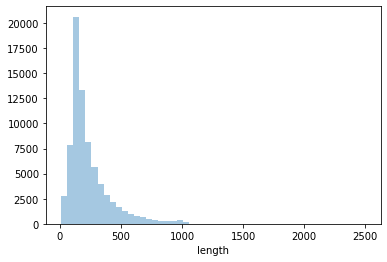

In [ ]:
sns.distplot(trainPlusUnsupDf['length'],kde=False)

here we can see the distribution of length of input text mostly here i guess maxlen of 300 will be a good idea which kind of cover approx till 75 percentile of all the texts.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

In [ ]:
from scipy import sparse

In [ ]:
def pipelineBOW(data):
  tfidfVectorizer = TfidfVectorizer(tokenizer = tokenizerBOW,ngram_range=(1,3),sublinear_tf=1,strip_accents='unicode',max_features = 40000) 
  data=data.apply(lambda x:x.lower())
  data=data.apply(lambda x:BeautifulSoup(x,'html.parser').get_text())
  tfidfVectorizer.fit(data.values)
  print('TFIDF Done')
  return tfidfVectorizer

In [ ]:
def processData(data,tfidfVectorizer):
  data=data.apply(lambda x:x.lower())
  data=tfidfVectorizer.transform(data.values)
  return data

# Modelling

In [ ]:
from sklearn import model_selection

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
import numpy as np

In [ ]:
trainPlusUnsupDf.head()

,Text,TextTOK,length
0,oil industrialist leonard dawson had a __NUM__...,"[oil, industrialist, leonard, dawson, had, a, ...",213
1,having recently revisited my old van damme col...,"[having, recently, revisited, my, old, van, da...",940
2,i thought this might be funny going in and tay...,"[i, thought, this, might, be, funny, going, in...",210
3,one of the many movies that mistakes profanity...,"[one, of, the, many, movies, that, mistakes, p...",132
4,god will forgive them etc this is the best lin...,"[god, will, forgive, them, etc, this, is, the,...",245


In [ ]:
%%time
tfidfVectorizer=pipelineBOW(trainPlusUnsupDf['Text'])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


TFIDF Done
CPU times: user 3min 11s, sys: 366 ms, total: 3min 11s
Wall time: 3min 11s


In [ ]:
%%time
train=processData(trainDf['Text'],tfidfVectorizer)

CPU times: user 45.7 s, sys: 0 ns, total: 45.7 s
Wall time: 45.7 s


In [ ]:
%%time
test=processData(testDf['Text'],tfidfVectorizer)

CPU times: user 43.9 s, sys: 0 ns, total: 43.9 s
Wall time: 43.9 s


In [ ]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [ ]:
import optuna

Instead of handpickin parameter by myselfi automated the whole process using opuna where he choice of models are linear support vector machines, random forest and logistic regression.

Optuna by default uses TPE sampler.

According to the documentation:

This sampler is based on independent sampling. See also BaseSampler for more details of ‘independent sampling’.

On each trial, for each parameter, TPE fits one Gaussian Mixture Model (GMM) l(x) to the set of parameter values associated with the best objective values, and another GMM g(x) to the remaining parameter values. It chooses the parameter value x that maximizes the ratio l(x)/g(x).

In [ ]:
%%time
def objectiveSklearn(trial):

    classifier_name = trial.suggest_categorical('classifier', ['LogReg','SVC','RandomForest'])
    if classifier_name == 'LogReg':
         loss=trial.suggest_categorical("loss", ['l1', 'l2', 'elasticnet'])
         classifier_obj = LogisticRegression(class_weight='balanced',n_jobs=-1)
    if (classifier_name == 'SVC'):
        svc_c = trial.suggest_float("c", 1e-10, 1e10, log=True)
        classifier_obj = LinearSVC(C=svc_c)
    else:
        rf_max_depth = int(trial.suggest_int('rf_max_depth', 3, 15))
        n_est=int(trial.suggest_categorical("n_estimator", [100,200,300,400,500]))
        classifier_obj = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=n_est,n_jobs=-1)

    accuracy=cross_val_score(classifier_obj, train, trainDf['Label'].values, cv=3,n_jobs=-1)

    return np.mean(accuracy)

studySK = optuna.create_study(direction='maximize')
studySK.optimize(objectiveSklearn, n_trials=30)

[I 2020-12-04 13:28:48,002] A new study created in memory with name: no-name-1b77f598-6c55-4079-b4cf-c6288f590dbe
[I 2020-12-04 13:29:14,304] Trial 0 finished with value: 0.8346396922831557 and parameters: {'classifier': 'LogReg', 'loss': 'l2', 'rf_max_depth': 12, 'n_estimator': 400}. Best is trial 0 with value: 0.8346396922831557.
[I 2020-12-04 13:29:22,459] Trial 1 finished with value: 0.8660798555772325 and parameters: {'classifier': 'SVC', 'c': 1112.8121932926088}. Best is trial 1 with value: 0.8660798555772325.
[I 2020-12-04 13:29:24,040] Trial 2 finished with value: 0.870639869991248 and parameters: {'classifier': 'SVC', 'c': 6.091001448466234}. Best is trial 2 with value: 0.870639869991248.
[I 2020-12-04 13:29:37,624] Trial 3 finished with value: 0.8310396010752837 and parameters: {'classifier': 'LogReg', 'loss': 'l1', 'rf_max_depth': 6, 'n_estimator': 400}. Best is trial 2 with value: 0.870639869991248.
[I 2020-12-04 13:29:43,109] Trial 4 finished with value: 0.8146395882233177

CPU times: user 1.49 s, sys: 136 ms, total: 1.62 s
Wall time: 2min 44s


In [ ]:
studySK.best_params

{'c': 0.46782324148727283, 'classifier': 'SVC'}

In [ ]:
svc=LinearSVC(C=studySK.best_params['c'])
svc.fit(train, trainDf['Label'].values)

LinearSVC(C=0.46782324148727283, class_weight=None, dual=True,
          fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
          max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
          tol=0.0001, verbose=0)

In [ ]:
print(classification_report(svc.predict(test),testDf['Label']))

              precision    recall  f1-score   support

         0.0       0.88      0.87      0.87     12646
         1.0       0.87      0.88      0.87     12354

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



The BOW models performs well infact one could use the unsupervised data also for TFIDF which gives us good result. Another imporvement could have been using truncated SVD in the pipeline to make it even more easier for models to fit. Since fitting models was not time taking much we could do an exhaustive search for hyperparameters and find good one for these models.

# FAST TEXT

Fast text expect inout data to be of a certain form hence we need to preprocess our data accordingly. It is a method for cpu utilisation and seems to be quite robust and compact

In [ ]:
!pip install fasttext

     |████████████████████████████████| 71kB 3.8MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3038678 sha256=402134e5718634d7967fe276865bdb4c7c97360bb7bb1ebc28bc25e836f1e89c
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


We clean minimally for deep learning models.

In [ ]:
trainDf['Text']=  trainDf['Text'].apply(lambda x:BeautifulSoup(x,'html.parser').get_text())
trainDf['Text'] = trainDf['Text'].str.lower()
trainDf['Text'] = trainDf['Text'].apply(alpha_num)
trainDf['Text'] = trainDf['Text'].apply(replace_num)

In [ ]:
testDf['Text']=  testDf['Text'].apply(lambda x:BeautifulSoup(x,'html.parser').get_text())
testDf['Text'] = testDf['Text'].str.lower()
testDf['Text'] = testDf['Text'].apply(alpha_num)
testDf['Text'] = testDf['Text'].apply(replace_num)

In [ ]:
def makeFastextData(data,dataset):
    with open('fasttext_input_imdb_'+dataset +'.txt', 'w') as f:
        for text,label in zip(data['Text'],data['Label']):
            f.writelines(f'__label__{label} {text}\n')

In [ ]:
makeFastextData(trainDf,'train')

In [ ]:
makeFastextData(testDf,'test')

In [ ]:
!wc fasttext_input_imdb_train.txt

   25000  5744161 32330565 fasttext_input_imdb_train.txt


In [ ]:
!wc fasttext_input_imdb_test.txt

   25000  5615443 31564214 fasttext_input_imdb_test.txt


Some extra preprocessing 

In [ ]:
!cat fasttext_input_imdb_train.txt | sed -e "s/\([.\!?,'/()]\)/ \1 /g" | tr "[:upper:]" "[:lower:]" > fasttext_input_imdb_train_proc.txt

In [ ]:
!cat fasttext_input_imdb_test.txt | sed -e "s/\([.\!?,'/()]\)/ \1 /g" | tr "[:upper:]" "[:lower:]" > fasttext_input_imdb_test_proc.txt

In [ ]:
!head -n 24000 fasttext_input_imdb_train_proc.txt > imdb_train.bin

In [ ]:
!tail -n 1000 fasttext_input_imdb_train_proc.txt > imdb_valid.bin

In [ ]:
!head -n 25000 fasttext_input_imdb_test_proc.txt > imdb_test.bin

In [ ]:
import fasttext

Here we use autotune funcionality of fasttext to find a perfect model for us by doing changes based on validation data. limited the duration to 100 for fast execution and also limit the size of the output model. For faster convergence we use hierarchical softmax as the loss.

In [ ]:
%%time
model = fasttext.train_supervised(input='imdb_train.bin',autotuneValidationFile='imdb_valid.bin',autotuneModelSize="2M", autotuneDuration=100, loss='hs')

CPU times: user 2min 22s, sys: 31.1 ms, total: 2min 22s
Wall time: 2min 22s


In [ ]:
_,precision,recall=model.test('imdb_test.bin')

In [ ]:
print('Precision:',precision,'recall:',recall)

Precision: 0.87892 recall: 0.87892


saved the model here in compact quantized form so that it can be use later.

In [ ]:
model.quantize(retrain=False)
model.save_model("model_filename.ftz")

Fast text is a very good easy to use and very well engineered solution which give great results too. i tried to search for a way to learn representation present in text and use it as a start for classification but could not find that bridge although one can learn the representation easily by using function learn_unsupervised 

# Sequence RNN

we use keras tokenizer trained on the unsupervised+training test and then transform test data using it as well as train. i experiment with 2 layer lstm structure for which we select hyperparameters using optuna again. used a 2 layer lstm structure for which we find optimal hyperparameter due to resource content and time needed by models to run we dont choose many trials.

In [ ]:
import tensorflow

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
t = Tokenizer()
t.fit_on_texts(trainPlusUnsupDf['Text'].values)

In [ ]:
trainText = t.texts_to_sequences(trainDf['Text'].values)

In [ ]:
testText = t.texts_to_sequences(testDf['Text'].values)

In [ ]:
trainTextPadded=tensorflow.keras.preprocessing.sequence.pad_sequences(trainText, maxlen=300, dtype='int32', padding='post', truncating='post')

In [ ]:
testTextPadded=tensorflow.keras.preprocessing.sequence.pad_sequences(testText, maxlen=300, dtype='int32', padding='post', truncating='post')

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras.layers import LSTM,Embedding,GRU,Dense,Input,Dropout,Bidirectional
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop,Adam


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(trainTextPadded, trainDf['Label'], test_size=0.2, random_state=42)

In [ ]:
%%time
def objectiveLSTM(trial):
    inpt = Input(shape = (300,))
    embedding = Embedding(len(t.word_index) + 1,output_dim=trial.suggest_categorical("embedding", [50,100]), input_length=300, mask_zero=True)(inpt)
    LSTM1=Bidirectional(LSTM(units=trial.suggest_categorical("units1", [64,128,256]),return_sequences=True))(embedding)
    dropout=Dropout(rate=trial.suggest_loguniform('dropout', 1e-1, 5e-1))(LSTM1)
    LSTM2=Bidirectional(LSTM(units=trial.suggest_categorical("units2", [32,64,128]),return_sequences=False))(dropout)
    output=Dense(1, activation='sigmoid')(LSTM2)
    model=Model(inpt,output)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=lr), metrics=['accuracy'])
    model.fit(X_train,y_train,validation_split=0.1,shuffle=True,batch_size=512,epochs=10,verbose=True)
    accuracy=model.evaluate(X_test,y_test)
    return accuracy[0]
studyDL = optuna.create_study(direction='minimize')
studyDL.optimize(objectiveLSTM, n_trials=5)

[I 2020-12-04 15:56:48,108] A new study created in memory with name: no-name-63df6f6a-b44a-48ca-9ae5-105f9e61f3a7


Epoch 1/10
36/36 [==============================] - 14s 377ms/step - loss: 0.6842 - accuracy: 0.6080 - val_loss: 0.6049 - val_accuracy: 0.6760
Epoch 2/10
36/36 [==============================] - 9s 259ms/step - loss: 0.5117 - accuracy: 0.7650 - val_loss: 0.4550 - val_accuracy: 0.7850
Epoch 3/10
36/36 [==============================] - 9s 259ms/step - loss: 0.3579 - accuracy: 0.8429 - val_loss: 0.5821 - val_accuracy: 0.7550
Epoch 4/10
36/36 [==============================] - 9s 259ms/step - loss: 0.2589 - accuracy: 0.8945 - val_loss: 0.5419 - val_accuracy: 0.7770
Epoch 5/10
36/36 [==============================] - 9s 258ms/step - loss: 0.1753 - accuracy: 0.9327 - val_loss: 0.6102 - val_accuracy: 0.7345
Epoch 6/10
36/36 [==============================] - 9s 259ms/step - loss: 0.1415 - accuracy: 0.9468 - val_loss: 0.5000 - val_accuracy: 0.8165
Epoch 7/10
36/36 [==============================] - 9s 259ms/step - loss: 0.0930 - accuracy: 0.9638 - val_loss: 0.9224 - val_accuracy: 0.6855
Epoch

[I 2020-12-04 15:58:59,365] Trial 0 finished with value: 0.6811148524284363 and parameters: {'embedding': 50, 'units1': 64, 'dropout': 0.22504036672028457, 'units2': 32, 'lr': 0.008674885296861211}. Best is trial 0 with value: 0.6811148524284363.


Epoch 1/10
36/36 [==============================] - 14s 385ms/step - loss: 0.6923 - accuracy: 0.5211 - val_loss: 0.6897 - val_accuracy: 0.5410
Epoch 2/10
36/36 [==============================] - 10s 274ms/step - loss: 0.6286 - accuracy: 0.6923 - val_loss: 0.4985 - val_accuracy: 0.7650
Epoch 3/10
36/36 [==============================] - 10s 274ms/step - loss: 0.4178 - accuracy: 0.8182 - val_loss: 0.4259 - val_accuracy: 0.8110
Epoch 4/10
36/36 [==============================] - 10s 273ms/step - loss: 0.3308 - accuracy: 0.8665 - val_loss: 0.3624 - val_accuracy: 0.8455
Epoch 5/10
36/36 [==============================] - 10s 273ms/step - loss: 0.2694 - accuracy: 0.8977 - val_loss: 0.3391 - val_accuracy: 0.8675
Epoch 6/10
36/36 [==============================] - 10s 272ms/step - loss: 0.2275 - accuracy: 0.9151 - val_loss: 0.3360 - val_accuracy: 0.8775
Epoch 7/10
36/36 [==============================] - 10s 273ms/step - loss: 0.1878 - accuracy: 0.9328 - val_loss: 0.4527 - val_accuracy: 0.8445

[I 2020-12-04 16:01:04,098] Trial 1 finished with value: 0.38028624653816223 and parameters: {'embedding': 50, 'units1': 64, 'dropout': 0.3706454194859867, 'units2': 64, 'lr': 0.00016189924268387887}. Best is trial 1 with value: 0.38028624653816223.


Epoch 1/10
36/36 [==============================] - 13s 374ms/step - loss: 0.6136 - accuracy: 0.6732 - val_loss: 0.4087 - val_accuracy: 0.8200
Epoch 2/10
36/36 [==============================] - 10s 274ms/step - loss: 0.3540 - accuracy: 0.8510 - val_loss: 0.4048 - val_accuracy: 0.8260
Epoch 3/10
36/36 [==============================] - 10s 274ms/step - loss: 0.2343 - accuracy: 0.9084 - val_loss: 0.3642 - val_accuracy: 0.8550
Epoch 4/10
36/36 [==============================] - 10s 273ms/step - loss: 0.1784 - accuracy: 0.9336 - val_loss: 0.3657 - val_accuracy: 0.8660
Epoch 5/10
36/36 [==============================] - 10s 273ms/step - loss: 0.1308 - accuracy: 0.9510 - val_loss: 0.4816 - val_accuracy: 0.8545
Epoch 6/10
36/36 [==============================] - 10s 272ms/step - loss: 0.0933 - accuracy: 0.9664 - val_loss: 0.4857 - val_accuracy: 0.7950
Epoch 7/10
36/36 [==============================] - 10s 273ms/step - loss: 0.0546 - accuracy: 0.9820 - val_loss: 0.5534 - val_accuracy: 0.8635

[I 2020-12-04 16:03:08,472] Trial 2 finished with value: 0.5836058855056763 and parameters: {'embedding': 50, 'units1': 64, 'dropout': 0.1275607257989057, 'units2': 64, 'lr': 0.0020301932674781486}. Best is trial 1 with value: 0.38028624653816223.


Epoch 1/10
36/36 [==============================] - 19s 514ms/step - loss: 0.6922 - accuracy: 0.5332 - val_loss: 0.6908 - val_accuracy: 0.5860
Epoch 2/10
36/36 [==============================] - 15s 415ms/step - loss: 0.6754 - accuracy: 0.6570 - val_loss: 0.5943 - val_accuracy: 0.7025
Epoch 3/10
36/36 [==============================] - 15s 414ms/step - loss: 0.5075 - accuracy: 0.7626 - val_loss: 0.4557 - val_accuracy: 0.7970
Epoch 4/10
36/36 [==============================] - 15s 415ms/step - loss: 0.3980 - accuracy: 0.8305 - val_loss: 0.4485 - val_accuracy: 0.8050
Epoch 5/10
36/36 [==============================] - 15s 412ms/step - loss: 0.3251 - accuracy: 0.8691 - val_loss: 0.4432 - val_accuracy: 0.8120
Epoch 6/10
36/36 [==============================] - 15s 417ms/step - loss: 0.2710 - accuracy: 0.8966 - val_loss: 0.3585 - val_accuracy: 0.8470
Epoch 7/10
36/36 [==============================] - 15s 415ms/step - loss: 0.2351 - accuracy: 0.9135 - val_loss: 0.3566 - val_accuracy: 0.8560

[I 2020-12-04 16:06:05,257] Trial 3 finished with value: 0.4163428843021393 and parameters: {'embedding': 100, 'units1': 128, 'dropout': 0.2709290810082003, 'units2': 64, 'lr': 9.041356047814194e-05}. Best is trial 1 with value: 0.38028624653816223.


Epoch 1/10
36/36 [==============================] - 16s 451ms/step - loss: 0.6749 - accuracy: 0.6149 - val_loss: 0.5397 - val_accuracy: 0.7425
Epoch 2/10
36/36 [==============================] - 12s 338ms/step - loss: 0.4680 - accuracy: 0.7923 - val_loss: 0.7116 - val_accuracy: 0.6825
Epoch 3/10
36/36 [==============================] - 12s 338ms/step - loss: 0.4096 - accuracy: 0.8179 - val_loss: 0.4056 - val_accuracy: 0.8115
Epoch 4/10
36/36 [==============================] - 12s 338ms/step - loss: 0.2572 - accuracy: 0.8961 - val_loss: 0.4227 - val_accuracy: 0.8235
Epoch 5/10
36/36 [==============================] - 12s 338ms/step - loss: 0.1988 - accuracy: 0.9237 - val_loss: 0.7829 - val_accuracy: 0.7080
Epoch 6/10
36/36 [==============================] - 12s 338ms/step - loss: 0.1731 - accuracy: 0.9328 - val_loss: 0.4729 - val_accuracy: 0.8015
Epoch 7/10
36/36 [==============================] - 12s 337ms/step - loss: 0.1406 - accuracy: 0.9492 - val_loss: 0.8127 - val_accuracy: 0.7070

[I 2020-12-04 16:08:33,779] Trial 4 finished with value: 1.2457996606826782 and parameters: {'embedding': 50, 'units1': 128, 'dropout': 0.3363530997614701, 'units2': 32, 'lr': 0.003724474987378308}. Best is trial 1 with value: 0.38028624653816223.


CPU times: user 7min 47s, sys: 28.5 s, total: 8min 16s
Wall time: 11min 45s


In [ ]:
studyDL.best_params

{'dropout': 0.3706454194859867,
 'embedding': 50,
 'lr': 0.00016189924268387887,
 'units1': 64,
 'units2': 64}

In [ ]:
studyDL.best_trial

FrozenTrial(number=1, value=0.38028624653816223, datetime_start=datetime.datetime(2020, 12, 4, 15, 58, 59, 366599), datetime_complete=datetime.datetime(2020, 12, 4, 16, 1, 4, 97783), params={'embedding': 50, 'units1': 64, 'dropout': 0.3706454194859867, 'units2': 64, 'lr': 0.00016189924268387887}, distributions={'embedding': CategoricalDistribution(choices=(50, 100)), 'units1': CategoricalDistribution(choices=(64, 128, 256)), 'dropout': LogUniformDistribution(high=0.5, low=0.1), 'units2': CategoricalDistribution(choices=(32, 64, 128)), 'lr': LogUniformDistribution(high=0.01, low=1e-05)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=1, state=TrialState.COMPLETE)

So for using pretrained embedding we used here glove and fasttext embeddign which initiliases the weights of our embedding layer and we set it trainable to false

In [ ]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

--2020-12-04 14:32:47--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2020-12-04 14:32:48--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2020-12-04 14:32:48--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

In [ ]:
!unzip glove.twitter.27B.zip

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
replace glove.twitter.27B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2020-12-04 14:48:01--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  12.5MB/s    in 53s     

2020-12-04 14:48:56 (12.2 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [ ]:
!unzip wiki-news-300d-1M.vec.zip

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [ ]:
import numpy as np

In [ ]:
def embeddingWeights(embeddingType,word_index):
  embeddings_index = {}
  if(embeddingType=='glove'):
    f = open('glove.twitter.27B.50d.txt')
    EMBEDDING_DIM=50
  else:
    f = open('wiki-news-300d-1M.vec')
    EMBEDDING_DIM=300
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
  f.close()

  embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
  return embedding_matrix,EMBEDDING_DIM

In [ ]:
%%time
glove,emd=embeddingWeights('glove',t.word_index)

CPU times: user 17.1 s, sys: 958 ms, total: 18 s
Wall time: 18 s


In [ ]:
%%time
fasttext,embd=embeddingWeights('fasttext',t.word_index)

CPU times: user 1min 5s, sys: 3.01 s, total: 1min 8s
Wall time: 1min 8s


In [ ]:
def makeLSTM(embedding,dropout,lr,units1,units2,usePretrained,embedding_matrix):
    inpt = Input(shape = (300,))
    if(not usePretrained):
      embedding = Embedding(len(t.word_index) + 1,output_dim=embedding, input_length=300, mask_zero=True)(inpt)
    else:
      embedding = Embedding(len(t.word_index) + 1,output_dim=embedding, input_length=300, mask_zero=True,weights=[embedding_matrix],trainable=False)(inpt)

    LSTM1=Bidirectional(LSTM(units=units1,return_sequences=True))(embedding)
    drop=Dropout(rate=dropout)(LSTM1)
    LSTM2=Bidirectional(LSTM(units=units2,return_sequences=False))(drop)
    output=Dense(1, activation='sigmoid')(LSTM2)
    model=Model(inpt,output)
    model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=lr), metrics=['accuracy'])
    model.fit(trainTextPadded,trainDf['Label'].values,validation_split=0.1,shuffle=True,batch_size=512,epochs=10,verbose=True)
    return model

Now we use the params we found using optuna for lstm based models.

{'dropout': 0.3706454194859867,
 'embedding': 50,
 'lr': 0.00016189924268387887,
 'units1': 64,
 'units2': 64}

In [ ]:
modelLSTM=makeLSTM(50,0.37,0.00016,64,64,False,None)

Epoch 1/10
44/44 [==============================] - 16s 370ms/step - loss: 0.6898 - accuracy: 0.5742 - val_loss: 0.6753 - val_accuracy: 0.6944
Epoch 2/10
44/44 [==============================] - 12s 283ms/step - loss: 0.5134 - accuracy: 0.7696 - val_loss: 0.4666 - val_accuracy: 0.7824
Epoch 3/10
44/44 [==============================] - 12s 283ms/step - loss: 0.3553 - accuracy: 0.8519 - val_loss: 0.4220 - val_accuracy: 0.8084
Epoch 4/10
44/44 [==============================] - 12s 283ms/step - loss: 0.2882 - accuracy: 0.8859 - val_loss: 0.3599 - val_accuracy: 0.8428
Epoch 5/10
44/44 [==============================] - 12s 282ms/step - loss: 0.2342 - accuracy: 0.9120 - val_loss: 0.3435 - val_accuracy: 0.8568
Epoch 6/10
44/44 [==============================] - 12s 284ms/step - loss: 0.1997 - accuracy: 0.9261 - val_loss: 0.3219 - val_accuracy: 0.8772
Epoch 7/10
44/44 [==============================] - 12s 284ms/step - loss: 0.1648 - accuracy: 0.9422 - val_loss: 0.3309 - val_accuracy: 0.8776

In [ ]:
modelLSTM.evaluate(testTextPadded,testDf['Label'])

782/782 [==============================] - 18s 22ms/step - loss: 0.4298 - accuracy: 0.8522


[0.42976242303848267, 0.8522400259971619]

In [ ]:
modelLSTMGlove=makeLSTM(50,0.37,0.00016,64,64,True,glove)

Epoch 1/10
44/44 [==============================] - 14s 317ms/step - loss: 0.6733 - accuracy: 0.5908 - val_loss: 0.6399 - val_accuracy: 0.6396
Epoch 2/10
44/44 [==============================] - 10s 236ms/step - loss: 0.5996 - accuracy: 0.6828 - val_loss: 0.5484 - val_accuracy: 0.7224
Epoch 3/10
44/44 [==============================] - 10s 235ms/step - loss: 0.5605 - accuracy: 0.7183 - val_loss: 0.5308 - val_accuracy: 0.7412
Epoch 4/10
44/44 [==============================] - 10s 236ms/step - loss: 0.5487 - accuracy: 0.7259 - val_loss: 0.5198 - val_accuracy: 0.7500
Epoch 5/10
44/44 [==============================] - 10s 236ms/step - loss: 0.5344 - accuracy: 0.7363 - val_loss: 0.5922 - val_accuracy: 0.6804
Epoch 6/10
44/44 [==============================] - 10s 236ms/step - loss: 0.5264 - accuracy: 0.7410 - val_loss: 0.5494 - val_accuracy: 0.7336
Epoch 7/10
44/44 [==============================] - 10s 236ms/step - loss: 0.5217 - accuracy: 0.7460 - val_loss: 0.5292 - val_accuracy: 0.7356

In [ ]:
modelLSTMGlove.evaluate(testTextPadded,testDf['Label'])

782/782 [==============================] - 18s 23ms/step - loss: 0.5002 - accuracy: 0.7660


[0.5001837015151978, 0.766040027141571]

Keeping all the parameters same as that of simple lstm(flexible embedding layers)vs glove embedding layer we see the drop in performance which is quite explainable by the fact that text used train glove is different from the text here (even tho its text from twitter). Moreover can also see that the model takes more time to fit (train accuracy) but this could improve with more epoch or using high dimensional embedding of glove. could also have more complicated achitechtures and more intensive hyperparameter search but for now due to resource contraint we limit ourselves.

Since the embedding size offered by fasttext is bigger it might be good idea to use more units of lstm.

In [ ]:
modelLSTMfasttext=makeLSTM(300,0.37,0.00016,128,64,True,fasttext)

Epoch 1/10
44/44 [==============================] - 23s 517ms/step - loss: 0.6563 - accuracy: 0.6223 - val_loss: 0.7108 - val_accuracy: 0.5560
Epoch 2/10
44/44 [==============================] - 19s 439ms/step - loss: 0.5511 - accuracy: 0.7198 - val_loss: 0.4735 - val_accuracy: 0.7880
Epoch 3/10
44/44 [==============================] - 19s 438ms/step - loss: 0.4919 - accuracy: 0.7630 - val_loss: 0.4836 - val_accuracy: 0.7688
Epoch 4/10
44/44 [==============================] - 19s 437ms/step - loss: 0.4570 - accuracy: 0.7896 - val_loss: 0.5255 - val_accuracy: 0.7464
Epoch 5/10
44/44 [==============================] - 19s 438ms/step - loss: 0.4453 - accuracy: 0.7941 - val_loss: 0.5087 - val_accuracy: 0.7656
Epoch 6/10
44/44 [==============================] - 19s 437ms/step - loss: 0.4302 - accuracy: 0.8054 - val_loss: 0.4884 - val_accuracy: 0.7596
Epoch 7/10
44/44 [==============================] - 19s 436ms/step - loss: 0.4207 - accuracy: 0.8088 - val_loss: 0.4005 - val_accuracy: 0.8200

In [ ]:
modelLSTMfasttext.evaluate(testTextPadded,testDf['Label'])

782/782 [==============================] - 21s 27ms/step - loss: 0.3705 - accuracy: 0.8396


[0.37046363949775696, 0.8396000266075134]

Here we get reasonable accuracy but we had to use a slightly bigger model. But since its a bigger size vectors it can accomodate somehow. But we can see still wiki news contains corpus which is different from casual commenting on imdb by people.

contrasting performance of deep learning models with bag of words (fits faster to data aswell) model its interesting to notice that maybe indivisual words might play more role in determing the sentiment as compared to the full sequential structure. but one cannot say that with full certainity since didnt train our models for long enough neither explored more trials of hyperparameters.

# BERT BASED

So we try 2 variants of bert based models first by using distil bert from hugging face an then using ktrain to train the bigger bert.

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.4MB 5.6MB/s 
     |████████████████████████████████| 890kB 19.9MB/s 
     |████████████████████████████████| 2.9MB 28.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=a1ec9e5910bcec29fdd40a087b5167a0a7839887e10711dce208e8319dfc82e2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from transformers import DistilBertTokenizerFast, TFDistilBertModel

We almost used unprocessed data due to the nature of bert tokenizer and also we set do lower case to true which convert data to lower case since we use distilbert base uncased

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased', do_lower_case=True)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
bert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
bert.summary()

Model: "tf_distil_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
Total params: 66,362,880
Trainable params: 66,362,880
Non-trainable params: 0
_________________________________________________________________


For tokenisation we use fast encoder batch for distil bert which works very fast and automatically adds special tokens and does padding and truncation according to the max length.

In [ ]:
import numpy as np

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.batch_encode_plus(text_chunk,add_special_tokens=True,max_length=maxlen,padding=True,truncation=True)
        all_ids.extend(np.asarray(encs['input_ids']))
    return all_ids

In [ ]:
x_train = fast_encode(trainDf['Text'].astype(str), tokenizer, maxlen=300)
x_train=np.stack(x_train, axis=0)

In [ ]:
x_test = fast_encode(testDf['Text'].astype(str), tokenizer, maxlen=300)
x_test=np.stack(x_test, axis=0)

In [ ]:
y_train = trainDf['Label'].values
y_test = testDf['Label'].values

In [ ]:
from transformers import AdamWeightDecay,get_cosine_schedule_with_warmup

In [ ]:
def modelDBERT():
    input = Input(shape=(300,),dtype='int32')
    bert.trainable=True
    bertOp = bert(input)[0]
    cls_token = bertOp[:, 0, :]
    dropout=Dropout(0.1)(cls_token)
    dense1=Dense(128,activation='relu')(dropout)
    out = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=input, outputs=out)
    model.compile(Adam(lr=3e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

Here we just add a bit of dropout to somehow avoid overfiting and a dense layer to fine tune.

In [ ]:
modelbert=modelDBERT()

In [ ]:
modelbert.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist multiple                  66362880  
_________________________________________________________________
tf_op_layer_strided_slice_2  [(None, 768)]             0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               98432     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 66,461,441
Trainable params: 66,461,441
Non-trainable params: 0
__________________________________________

In [ ]:
modelbert.fit(x_train,y_train,validation_split=0.1,epochs=1,batch_size=16,verbose=1,shuffle=True)

1407/1407 [==============================] - 587s 418ms/step - loss: 0.2798 - accuracy: 0.8800 - val_loss: 0.1992 - val_accuracy: 0.9228


In [ ]:
modelbert.evaluate(x_test,y_test)

782/782 [==============================] - 196s 250ms/step - loss: 0.1960 - accuracy: 0.9227


[0.19601084291934967, 0.9226800203323364]

Accuracy wise we get the best results for bert. But one thing which i noticed was that pure fine tuning (freezing the bert layer) and tuning extra added layers doesnt work very well. what works is we update the whole model with a small learning rate so that the weights of bert are not disturbed much